# Imports and Data Preparation
We need torch_geometric to handle the sparse matrix math required for graph convolutions.

In [1]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.6 MB/s eta 0:00:00


In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch_geometric.loader import DataLoader as GraphLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Dataset, Data
import torch_geometric.utils as utils
from sklearn.metrics import f1_score, accuracy_score

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PlantGraphDataset(Dataset):
    def __init__(self, subset):
        super().__init__()
        self.subset = subset

    def len(self):
        return len(self.subset)

    def get(self, idx):
        img_tensor, label = self.subset[idx]
        # Downsample to 32x32 for graph nodes
        img = F.interpolate(img_tensor.unsqueeze(0), size=(32, 32)).squeeze(0)
        x = img.view(img.shape[0], -1).t() # Features [1024, 3]
        edge_index, _ = utils.grid(32, 32) # 8-neighbor grid
        return Data(x=x, edge_index=edge_index, y=torch.tensor(label))

# Preprocessing & Data Splits
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder('/kaggle/input/plantvillage-dataset/color', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_sub, val_sub, test_sub = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Loaders
train_loader = GraphLoader(PlantGraphDataset(train_sub), batch_size=32, shuffle=True)
val_loader = GraphLoader(PlantGraphDataset(val_sub), batch_size=32, shuffle=False)
test_loader = GraphLoader(PlantGraphDataset(test_sub), batch_size=32, shuffle=False)

# GCNN Model Definition

In [3]:
class PlantGCNN(nn.Module):
    def __init__(self, num_classes=38):
        super(PlantGCNN, self).__init__()
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch) 
        return self.fc(x)

model = PlantGCNN(num_classes=38).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training Loop and Performance Table

In [4]:
history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
           'val_loss': [], 'val_acc': [], 'val_f1': []}

print(f"{'Epoch':<8} | {'Val Acc':<12} | {'Val F1 (Macro)':<15} | {'Time (s)':<10}")
print("-" * 55)

for epoch in range(25):
    start_time = time.time()
    
    # Training
    model.train()
    t_loss, t_preds, t_labels = 0, [], []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item() * data.num_graphs
        t_preds.extend(out.argmax(dim=1).cpu().numpy())
        t_labels.extend(data.y.cpu().numpy())

    # Validation
    model.eval()
    v_loss, v_preds, v_labels = 0, [], []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            v_loss += loss.item() * data.num_graphs
            v_preds.extend(out.argmax(dim=1).cpu().numpy())
            v_labels.extend(data.y.cpu().numpy())

    # Metrics
    val_acc = accuracy_score(v_labels, v_preds)
    val_f1 = f1_score(v_labels, v_preds, average='macro')
    epoch_time = time.time() - start_time
    
    # Logging
    history['train_loss'].append(t_loss / len(train_sub))
    history['train_acc'].append(accuracy_score(t_labels, t_preds))
    history['train_f1'].append(f1_score(t_labels, t_preds, average='macro'))
    history['val_loss'].append(v_loss / len(val_sub))
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"{epoch+1:<8} | {val_acc:<12.4f} | {val_f1:<15.4f} | {epoch_time:<10.1f}")

Epoch    | Val Acc      | Val F1 (Macro)  | Time (s)  
-------------------------------------------------------
1        | 0.5192       | 0.3598          | 342.7     
2        | 0.6534       | 0.5413          | 200.3     
3        | 0.6930       | 0.5841          | 201.6     
4        | 0.7192       | 0.6334          | 201.6     
5        | 0.7431       | 0.6681          | 207.2     
6        | 0.7659       | 0.6855          | 205.8     
7        | 0.7827       | 0.7164          | 198.1     
8        | 0.7790       | 0.7118          | 200.3     
9        | 0.8020       | 0.7314          | 201.1     
10       | 0.8000       | 0.7406          | 200.8     
11       | 0.8131       | 0.7555          | 201.2     
12       | 0.8182       | 0.7605          | 198.0     
13       | 0.8053       | 0.7276          | 198.5     
14       | 0.8204       | 0.7641          | 199.4     
15       | 0.8274       | 0.7713          | 197.6     
16       | 0.8017       | 0.7297          | 196.9     
17       

# Visualization and Final Testing

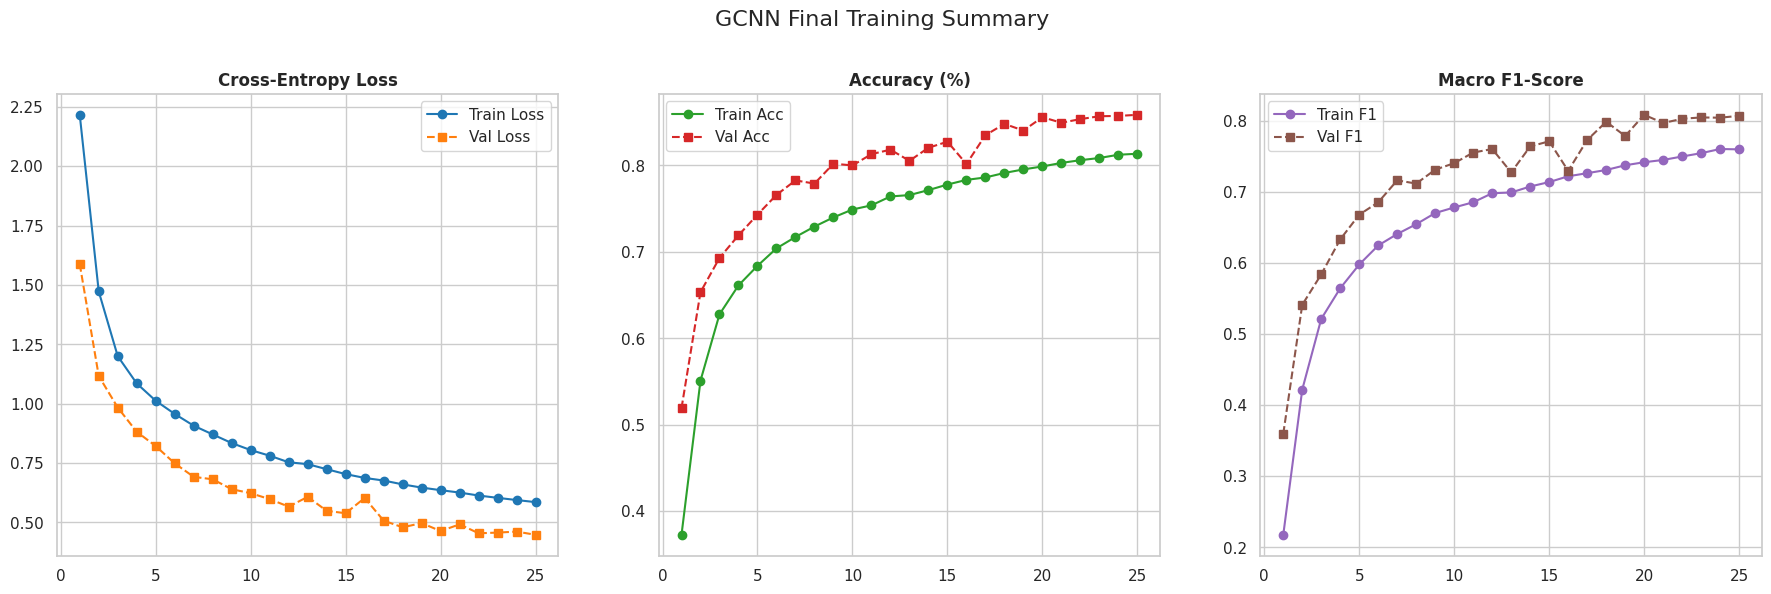


--- GCNN Test Results ---
Final Accuracy: 0.8626
Final Macro F1: 0.8128


In [5]:
def plot_training_performance(history):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    epochs = range(1, len(history['val_acc']) + 1)

    metrics = [('loss', 'Cross-Entropy Loss'), ('acc', 'Accuracy (%)'), ('f1', 'Macro F1-Score')]
    colors = [('#1f77b4', '#ff7f0e'), ('#2ca02c', '#d62728'), ('#9467bd', '#8c564b')]

    for i, (m, title) in enumerate(metrics):
        axes[i].plot(epochs, history[f'train_{m}'], 'o-', label=f'Train {m.capitalize()}', color=colors[i][0])
        axes[i].plot(epochs, history[f'val_{m}'], 's--', label=f'Val {m.capitalize()}', color=colors[i][1])
        axes[i].set_title(title, fontweight='bold')
        axes[i].legend()

    plt.suptitle('GCNN Final Training Summary', fontsize=16, y=1.02)
    plt.show()

plot_training_performance(history)

# --- Final Test Results ---
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        test_preds.extend(out.argmax(dim=1).cpu().numpy())
        test_labels.extend(data.y.cpu().numpy())

print("\n--- GCNN Test Results ---")
print(f"Final Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"Final Macro F1: {f1_score(test_labels, test_preds, average='macro'):.4f}")